In [110]:
import seastar as ss
import xarray as xr
import numpy as np
import pdb

In [112]:
along_length = 2
across_length = 2
level1 = xr.Dataset(
    data_vars=dict(
            CentralWavenumber=( [],270 ),
            CentralFreq=( [], 13.5 * 10**9 ),
            IncidenceAngleImage=(['along','across','Antenna'],
                     np.stack((np.full([along_length, across_length], 36.5),
                              np.full([along_length, across_length], 28.4),
                              np.full([along_length, across_length], 36.5)
                              ),axis=-1
                             )
                    ),
            AntennaAzimuthImage=(['along','across', 'Antenna'],
                           np.stack((np.full([along_length, across_length], 45),
                                     np.full([along_length, across_length], 90),
                                     np.full([along_length, across_length], 135)
                                     ), axis=-1)
                                ),
            Polarization=(['along','across','Antenna'],
                          np.stack((np.full([along_length, across_length], 'VV'),
                                    np.full([along_length, across_length], 'VV'),
                                    np.full([along_length, across_length], 'VV')
                                    ), axis=-1)
                         ),
    ),
    coords=dict(
            along=np.arange(0,along_length),
            across=np.arange(0,across_length),
            Antenna=['Fore','MidV','Aft'],
        ),
)
level1 = level1.set_coords([
    'CentralWavenumber','CentralFreq','IncidenceAngleImage','AntennaAzimuthImage','Polarization', 
])
geo = xr.Dataset(
        data_vars=dict(
            WindSpeed=(['along','across'], np.full([along_length, across_length], 5.)), #5m/s
            WindDirection=(['along','across'], np.full([along_length, across_length], 0.)), #0 degrees
            CurrentVelocity=(['along','across'], np.full([along_length, across_length], 0.6)), #0.6m/s
            CurrentDirection=(['along','across'], np.full([along_length, across_length], 150.)), 
        ),
        coords=dict(
            along=np.arange(0, along_length),
            across=np.arange(0,across_length),
        ),
    )
geo['EarthRelativeWindSpeed'] = geo.WindSpeed
geo['EarthRelativeWindDirection'] = geo.WindDirection
ss.utils.tools.EarthRelativeSpeedDir2all(geo)
geo['WindSpeed'] = geo.OceanSurfaceWindSpeed
geo['WindDirection'] = geo.OceanSurfaceWindDirection

gmf = {'doppler':{'name':'yurovsky19'}, 'nrcs':{'name':'nscat4ds'}}
level1['Sigma0'] = ss.gmfs.nrcs.compute_nrcs(level1, geo, gmf['nrcs'])

model_rsv_list = [None] * level1.Antenna.size
model_wasv_list = [None] * level1.Antenna.size
for aa, ant in enumerate(level1.Antenna.data):
    model_rsv_list[aa] = ss.gmfs.doppler.compute_total_surface_motion(level1.sel(Antenna=ant),
                                                                      geo,
                                                                      gmf=gmf['doppler']['name'])
level1['RSV'] = xr.concat(model_rsv_list, dim='Antenna')

level1['RSV'].loc[dict(Antenna='Fore')][1,1] = 100
#level1['Sigma0'].loc[dict(Antenna='Fore')][2,2] = ss.utils.tools.db2lin(200)

In [113]:
noise_RSV = 0.05
baseline_sigma0_noise = 0.03
baseline_mid_RSV_noise = 0.8
uncertainty = xr.Dataset(
        data_vars=dict(
            RSV=(['along','across','Antenna'],
                         np.stack((np.full([along_length, across_length], noise_RSV),
                                  np.full([along_length, across_length], baseline_mid_RSV_noise),
                                  np.full([along_length, across_length], noise_RSV)
                                  ),axis=-1
                                 )
                        ),
            Kp=(['along','across','Antenna'],
                         np.stack((np.full([along_length, across_length], baseline_sigma0_noise),
                                  np.full([along_length, across_length], baseline_sigma0_noise),
                                  np.full([along_length, across_length], baseline_sigma0_noise)
                                  ),axis=-1
                                 )
                        ),
        ),
        coords=dict(
                along=np.arange(0,along_length),
                across=np.arange(0,across_length),
                Antenna=['Fore','MidV','Aft'],
            ),
    )
uncertainty, noise = ss.performance.scene_generation.uncertainty_fct(level1, uncertainty)
level1n = ss.performance.scene_generation.noise_generation(level1, noise)

To Be Done - uncertainty function


In [ ]:
#pdb.set_trace()
lmout = ss.retrieval.level2.run_find_minima(level1n, noise, gmf, serial=False)

In [99]:
# success mask
bounds = lmout.bounds.isel(extrema=0, along=0, across=0).data
x_limit = [np.sqrt(bounds **2 + bounds **2)[i] for i in [0,2]]
mask = xr.where(lmout.success.sum(dim='Ambiguities') == len(lmout.Ambiguities), True, False)
#    and xr.where(np.abs(L2.CurrentVelocity - x_limit[1]) < 0.01, False, True)\
#    and xr.where(np.abs(L2.WindSpeed - x_limit[0]) < 0.01, False, True)

mask

<xarray.DataArray 'success' (along: 4, across: 4)>
array([[ True,  True,  True,  True],
       [ True, False,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])
Coordinates:
  * along              (along) int32 0 1 2 3
  * across             (across) int32 0 1 2 3
    CentralFreq        float64 1.35e+10
    CentralWavenumber  int32 270

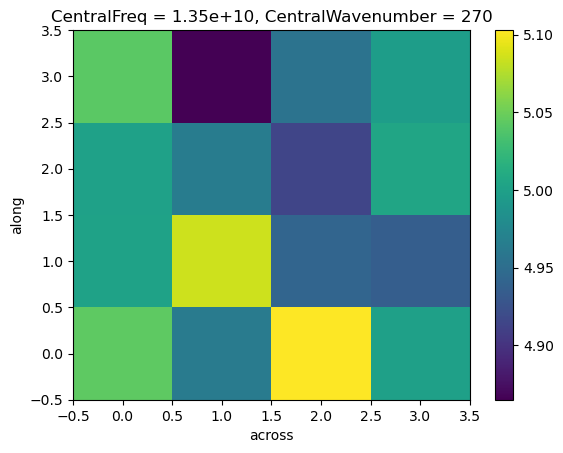

In [104]:
ambiguity = {'name':'sort_by_cost'}
#ambiguity = {'name':'closest_truth','truth':geo,'method':'wind'}
sol = ss.retrieval.ambiguity_removal.solve_ambiguity(lmout, ambiguity)
L2 = ss.retrieval.level2.sol2level2(sol)
mask = xr.where(lmout.success.sum(dim='Ambiguities') == len(lmout.Ambiguities), True, False)
xr.where(mask, L2.WindSpeed, np.nan).plot()

In [109]:
lmout

<xarray.Dataset>
Dimensions:              (along: 4, across: 4, x_variables: 4, Observables: 2,
                          Antenna: 3, Ambiguities: 4, fun_variables: 6,
                          extrema: 2)
Coordinates:
  * along                (along) int32 0 1 2 3
  * across               (across) int32 0 1 2 3
  * x_variables          (x_variables) <U3 'u' 'v' 'c_u' 'c_v'
  * Observables          (Observables) <U6 'sigma0' 'RSV'
  * Antenna              (Antenna) <U4 'Fore' 'MidV' 'Aft'
    fun_variables        (Observables, Antenna) int32 0 1 2 3 4 5
    CentralFreq          float64 1.35e+10
    CentralWavenumber    int32 270
    AntennaAzimuthImage  (Antenna) int32 45 90 135
    Polarization         (Antenna) <U2 'VV' 'VV' 'VV'
    IncidenceAngleImage  (Antenna) float64 36.5 28.4 36.5
Dimensions without coordinates: Ambiguities, extrema
Data variables: (12/17)
    x                    (Ambiguities, x_variables, along, across) float64 0....
    active_mask          (Ambiguities, x_variables, along, across) float64 0....
    grad                 (Ambiguities, x_variables, along, across) float64 -9...
    fun                  (Ambiguities, Observables, Antenna, along, across) float64 ...
    jac                  (Ambiguities, fun_variables, x_variables, along, across) float64 ...
    x0                   (Ambiguities, x_variables, along, across) float64 5....
    ...                   ...
    message              (Ambiguities, along, across) <U60 '`xtol` terminatio...
    success              (Ambiguities, along, across) bool True True ... True
    method               (along, across) <U3 'trf' 'trf' 'trf' ... 'trf' 'trf'
    xtol                 (along, across) float64 0.001 0.001 ... 0.001 0.001
    x_scale              (x_variables, along, across) float64 7.0 7.0 ... 0.5
    bounds               (extrema, x_variables, along, across) int32 -30 ... 5

In [24]:
np.sqrt(5**2+5**2)

7.0710678118654755

In [5]:
def noise_generation(truth, noise,seed=None):
    """

    :param truth:
    :param noise:
    :return:
    """

    level1 = noise.drop_vars(noise.data_vars)

    rng = np.random.default_rng(seed=seed)
    level1['Sigma0'] = truth.Sigma0 \
                       + noise.Sigma0 * rng.standard_normal(size=truth.Sigma0.shape) # Draw samples from a standard Normal distribution (mean=0, stdev=1).
    level1['RSV'] = truth.RSV \
                    + noise.RSV * rng.standard_normal(size=truth.RSV.shape)

    level1.RSV.attrs['long_name'] = 'Radial Surface Velocity'
    level1.RSV.attrs['units'] = 'm/s'

    return level1

In [16]:
opt = {
        'method': 'trf', # Trust Region Reflective algorithm, particularly suitable for large sparse problems with bounds. Generally robust method.
        'xtol':  1e-3, # Tolerance for termination by the change of the independent variables
        'x_scale': [7,7,.5,.5], # Characteristic scale of each variable.
        'bounds': ([-30,-30,-5,-5], [30,30,5,5]),
    } # if modified => change optionLeastSquares2dataset() below
init = [None] * 4
init[0] = dotdict({
        'x0': [ 7*np.random.normal(), #u
                7*np.random.normal(), #v
                0, # c_u
                0 ]  # c_v
    })
init[0] = dotdict({'x0':np.array([9.17751999, 2.66667487, 5.02169709, 4.64890949])})


In [19]:
(init[0].x0 > opt['bounds']).any()

True

In [48]:
def create_null_lmout_dict(lmout_dict):
    lmout_null = lmout_dict.copy()
    for var in lmout_dict.keys():
        if isinstance(lmout_dict[var],np.ndarray):
            lmout_null[var] = np.full(lmout_dict[var].shape, np.NaN)
        else:
            lmout_null[var] = np.NaN

    lmout_null['message'] = 'x0 found to be infeasible and out of bounds'
    lmout_null['success'] = False
    return lmout_null

In [22]:
lmout

<xarray.Dataset>
Dimensions:              (along: 2, across: 2, x_variables: 4, Observables: 2,
                          Antenna: 3, Ambiguities: 4, fun_variables: 6,
                          extrema: 2)
Coordinates:
  * along                (along) int32 0 1
  * across               (across) int32 0 1
  * x_variables          (x_variables) <U3 'u' 'v' 'c_u' 'c_v'
  * Observables          (Observables) <U6 'sigma0' 'RSV'
  * Antenna              (Antenna) <U4 'Fore' 'MidV' 'Aft'
    fun_variables        (Observables, Antenna) int32 0 1 2 3 4 5
    CentralFreq          float64 1.35e+10
    CentralWavenumber    int32 270
    AntennaAzimuthImage  (Antenna) int32 45 90 135
    Polarization         (Antenna) <U2 'VV' 'VV' 'VV'
    IncidenceAngleImage  (Antenna) float64 36.5 28.4 36.5
Dimensions without coordinates: Ambiguities, extrema
Data variables: (12/17)
    x                    (Ambiguities, x_variables, along, across) float64 na...
    active_mask          (Ambiguities, x_variables, along, across) float64 na...
    grad                 (Ambiguities, x_variables, along, across) float64 na...
    fun                  (Ambiguities, Observables, Antenna, along, across) float64 ...
    jac                  (Ambiguities, fun_variables, x_variables, along, across) float64 ...
    x0                   (Ambiguities, x_variables, along, across) float64 -7...
    ...                   ...
    message              (Ambiguities, along, across) <U43 'x0 found to be in...
    success              (Ambiguities, along, across) bool False True ... False
    method               (along, across) <U3 'trf' 'trf' 'trf' 'trf'
    xtol                 (along, across) float64 0.001 0.001 0.001 0.001
    x_scale              (x_variables, along, across) float64 7.0 7.0 ... 0.5
    bounds               (extrema, x_variables, along, across) int32 -30 ... 5

In [20]:
lmout2

<xarray.DataArray 'bounds' (extrema: 2, x_variables: 4, along: 2, across: 2)>
array([[[[-30, -30],
         [-30, -30]],

        [[-30, -30],
         [-30, -30]],

        [[ -5,  -5],
         [ -5,  -5]],

        [[ -5,  -5],
         [ -5,  -5]]],


       [[[ 30,  30],
         [ 30,  30]],

        [[ 30,  30],
         [ 30,  30]],

        [[  5,   5],
         [  5,   5]],

        [[  5,   5],
         [  5,   5]]]])
Coordinates:
  * along              (along) int32 0 1
  * across             (across) int32 0 1
  * x_variables        (x_variables) <U3 'u' 'v' 'c_u' 'c_v'
    CentralFreq        float64 1.35e+10
    CentralWavenumber  int32 270
Dimensions without coordinates: extrema
Attributes:
    description:  Lower and upper bounds on independent variables. Defaults t...

In [17]:
lmout2 = lmout.copy()
for var in lmout2.data_vars:
        if isinstance(lmout2[var],np.ndarray):
            print(lmout2[var])
            #lmout2[var] = np.full(lmout_dict[var].shape, np.NaN)
        #else:
           # lmout2[var] = np.NaN
lmout2

<xarray.Dataset>
Dimensions:              (along: 2, across: 2, x_variables: 4, Observables: 2,
                          Antenna: 3, Ambiguities: 4, fun_variables: 6,
                          extrema: 2)
Coordinates:
  * along                (along) int32 0 1
  * across               (across) int32 0 1
  * x_variables          (x_variables) <U3 'u' 'v' 'c_u' 'c_v'
  * Observables          (Observables) <U6 'sigma0' 'RSV'
  * Antenna              (Antenna) <U4 'Fore' 'MidV' 'Aft'
    fun_variables        (Observables, Antenna) int32 0 1 2 3 4 5
    CentralFreq          float64 1.35e+10
    CentralWavenumber    int32 270
    AntennaAzimuthImage  (Antenna) int32 45 90 135
    Polarization         (Antenna) <U2 'VV' 'VV' 'VV'
    IncidenceAngleImage  (Antenna) float64 36.5 28.4 36.5
Dimensions without coordinates: Ambiguities, extrema
Data variables: (12/17)
    x                    (Ambiguities, x_variables, along, across) float64 na...
    active_mask          (Ambiguities, x_variables, along, across) float64 na...
    grad                 (Ambiguities, x_variables, along, across) float64 na...
    fun                  (Ambiguities, Observables, Antenna, along, across) float64 ...
    jac                  (Ambiguities, fun_variables, x_variables, along, across) float64 ...
    x0                   (Ambiguities, x_variables, along, across) float64 -7...
    ...                   ...
    message              (Ambiguities, along, across) <U43 'x0 found to be in...
    success              (Ambiguities, along, across) bool False True ... False
    method               (along, across) <U3 'trf' 'trf' 'trf' 'trf'
    xtol                 (along, across) float64 0.001 0.001 0.001 0.001
    x_scale              (x_variables, along, across) float64 7.0 7.0 ... 0.5
    bounds               (extrema, x_variables, along, across) int32 -30 ... 5